# agent的功能详解

因为做为收集信息的agnet，主要的考虑是不想使用那么多的第三方库，能用自身的库和shell命令实现是最好的。最终版本的agent最好是使用root用户来执行。
下面的笔记中，因为是在pi用户中执行，所以在命令中添加了一个sudo下去。所有的试验和输出结果在在raspiso的x_86架构的虚拟机中执行的，代码在树莓派的真机中也算实验通过，可以正常获取到数据的。
需要导入的库包括了一下的这些

In [9]:
import platform
import socket
import os
import uuid
import re
import redis

### 获取系统信息的功能

In [5]:
info = platform.uname()
system = info[0]
node = info[1]
release = info[2]
version = info[3]
machine = info[4]

hostname = socket.gethostname()
host_ip = os.popen("hostname -I").readline().replace('\n', '')
mac = uuid.uuid1().hex
mac = mac[-12:].upper()
mac_address = re.findall(r".{2}", mac)
mac_address = ':'.join(mac_address)

uptime = os.popen(
    "uptime|awk -F ',' '{print $1}'|awk '{print $3}'").readline().replace('\n', '')

cpu_num = os.popen("grep 'processor' /proc/cpuinfo|wc -l").readline().replace('\n', '')
cpu_modelname = os.popen(
    "grep 'model name' /proc/cpuinfo|awk -F ': ' '{print $2}'").readline().replace('\n', '')
cpu_model = os.popen(
    "grep 'model' /proc/cpuinfo|awk -F ': ' '{print $2}'").readline().replace('\n', '')

sysinfo = {"os_system": system, "os_node": node, "os_release": release, "os_version": version,
           "os_machine": machine,
           "hostname": hostname, "host_ip": host_ip, "mac_address": mac_address,
           "uptime": uptime, "cpu_num": cpu_num, "cpu_modelname": cpu_modelname, "cpu_model": cpu_model, }

print(sysinfo)

{'os_system': 'Linux', 'os_node': 'raspberrypi', 'os_release': '5.10.17-v7l+', 'os_version': '#1403 SMP Mon Feb 22 11:33:35 GMT 2021', 'os_machine': 'armv7l', 'hostname': 'raspberrypi', 'host_ip': '192.168.1.88 ', 'mac_address': 'DC:A6:32:83:2A:EC', 'uptime': '8', 'cpu_num': '4', 'cpu_modelname': 'ARMv7 Processor rev 3 (v7l)', 'cpu_model': 'ARMv7 Processor rev 3 (v7l)'}


第1～5行：导入获取数据需要的各个标准库。

第7～12行：通过platform库的uname函数，获取系统的信息，获取的结果如下所示：

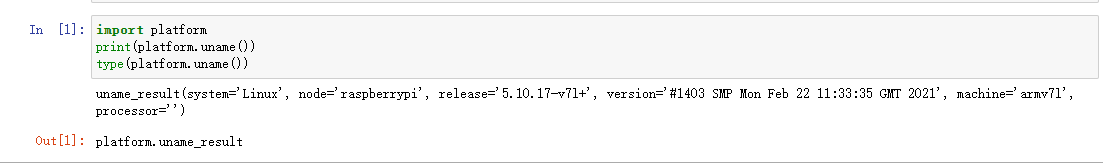

uname_result(system='Linux', node='raspberrypi', release='5.10.17-v7l+', version='#1403 SMP Mon Feb 22 11:33:35 GMT 2021', machine='armv7l', processor='')

它是一个platform.uname_result的结果，但是他可以直接通过下标索引来拿到结果，这个结果和通过uname-a得到的结果是类似的。
system='Linux'，也就是返回结果下标0的元素的信息（代表的是系统类型，因为树莓派的系统是基于Linux的Debian发行版本改造而来的，所以这里获取到的数据是Linux）； node='raspberry'也就是返回结果下标1的元素的信息（代表的是获取节点名，也可以说是主机名）, release=''5.10.17-v7l+'也就是返回结果下标2的元素的信息（当前系统的内核版本）, version='#1403 SMP Mon Feb 22 11:33:35 GMT 2021'也就是返回结果下标3的元素的信息（内核版本）, machine='armv7l'也就是返回结果下标4的元素的信息（当前系统的硬件架构）, processor=''也就是返回结果下标5的元素的信息

第14行：利用socket库的hostname函数去获取到系统的主机名（其实这个是可以不用的）。

第15行：通过os的popen函数，直接在shell里面执行hostname -I命令，直接获取到网卡的ip。hostname -I的意思是，显示主机的所有网络地址，它枚举了所有已配置的地址将其显示出来。但是会忽略掉loopback的回调地址和IPv6的地址。很适合在这里使用获取主机的ip地址。hostname还有一个小写的-i参数，也可以获取到ip，但是仅在主机名可以被解析的时候，才能使用，man文档中，是建议尽量避免使用小写i的参数，使用大写I的参数。

第17～19行：本来也是可以通过上面的ip address命令来获取到信息的，但是反正都要对数据做大写的处理，所以就直接使用了内置的uuid库去除mac地址的内容并且通过正则将其格式化为需要的的mac地址类型（AA:BB:CC:DD:EE:FF）这种形式。

第21行：通过os的popen函数，直接在shell里面执行uptime命令。然后获取系统的运行时间。

第22行：通过获取/proc/cpuinfo文件里面的processor字段，来得出cpu的核心数

第23行：通过获取/proc/cpuinfo文件里面的model name字段，从而得到了cpu的型号名

第24行：通过获取/proc/cpuinfo文件里面的model name字段，从而得到了cpu的型号

cpu的型号名和型号，在arm架构的树莓派里面，是一样的。如果是x_86架构的Inter的CPU，这个两个获取到的数值是不同的。

这个agent的最后是会通过rest的api接口的传数据，所以在第30行，将获取到的数据，组合成一个字典的形式。在后期调用的使用，就可以直接用json.dumps函数将其转化为json格式，传给接口。

### 获取内存信息的功能

In [3]:
mem_total = os.popen("free -m|awk '/Mem:/||/内存：/ {print $2}'").readline()
mem_used = os.popen("free -m|awk '/Mem:/||/内存：/  {print $3}'").readline()
mem_free = os.popen("free -m|awk '/Mem:/||/内存：/  {print $4}'").readline()
mem_shared = os.popen("free -m|awk '/Mem:/||/内存：/  {print $5}'").readline()
mem_buff = os.popen("free -m|awk '/Mem:/ ||/内存：/ {print $6}'").readline()
mem_available = os.popen(
    "free -m|awk '/Mem:/||/内存：/  {print $7}'").readline()

swap_total = os.popen(
    "free -m|awk '/Swap:/||/交换：/  {print $2}'").readline()
swap_used = os.popen("free -m|awk '/Swap:/||/交换：/  {print $3}'").readline()
swap_free = os.popen("free -m|awk '/Swap:/||/交换：/  {print $4}'").readline()

meminfo = {"mem_total": mem_total.replace('\n', '') + "M", "mem_used": mem_used.replace('\n', '') + "M",
           "mem_free": mem_free.replace('\n', '') + "M", "mem_shared": mem_shared.replace('\n', '') + "M",
           "mem_buff": mem_buff.replace('\n', '') + "M", "mem_available": mem_available.replace('\n', '') + "M",
           "swap_total": swap_total.replace('\n', '') + "M", "swap_used": swap_used.replace('\n', '') + "M",
           "swap_free": swap_free.replace('\n', '') + "M", }

print(meminfo)

{'mem_total': '3827M', 'mem_used': '168M', 'mem_free': '3079M', 'mem_shared': '56M', 'mem_buff': '579M', 'mem_available': '3449M', 'swap_total': '4095M', 'swap_used': '124M', 'swap_free': '3971M'}


获取内存信息的功能代码相对比较简单，就是通过直接在shell里面执行free -m的命令，然后把数据通过awk取行和分割，得到了物理内存和交换空间的总量、已用、可用、缓冲区、共享内存等等信息。

### 获取CPU信息的功能

In [4]:
cpu_user_precent = os.popen(
    "top -bn1|awk -F ' ' '/%Cpu/ {print $2}'").readline()
cpu_sys_precent = os.popen(
    "top -bn1|awk -F ' ' '/%Cpu/ {print $4}'").readline()
cpu_load_averages1 = os.popen(
    "uptime|awk -F 'load average:' '{print $2}'|awk -F ',' '{print $1}'").readline()
cpu_load_averages5 = os.popen(
    "uptime|awk -F 'load average:' '{print $2}'|awk -F ',' '{print $2}'").readline()
cpu_load_averages15 = os.popen(
    "uptime|awk -F 'load average:' '{print $2}'|awk -F ',' '{print $3}'").readline()

cpuinfo = {"cpu_user_precent": cpu_user_precent.replace('\n', ''),
           "cpu_sys_precent": cpu_sys_precent.replace('\n', ''),
           "cpu_load_averages1": cpu_load_averages1.replace('\n', ''),
           "cpu_load_averages5": cpu_load_averages5.replace('\n', ''),
           "cpu_load_averages15": cpu_load_averages15.replace('\n', '')}

print(cpuinfo)

{'cpu_user_precent': '0.0', 'cpu_sys_precent': '4.4', 'cpu_load_averages1': ' 0.33', 'cpu_load_averages5': ' 0.36', 'cpu_load_averages15': ' 0.42'}


CPU信息的获取相对比较简单，通过top命令的第二行里面的数据获取用户和系统的使用百分比，uptime命令里面的一分钟，五分钟，十五分钟的平均负载情况。然后在组成一个dict。

### 获取磁盘空间信息的功能

In [ ]:
disk = os.popen(
    "df -Th|grep -v '/dev/loop'|awk '/^\/dev\// {print $0}'").readlines()
all_disk_info = []
for item in disk:
    disk_item = item.replace('\n', '').split(' ')
    while '' in disk_item:
        disk_item.remove('')
    diskinfo = {"mount_point": disk_item[6], "disk_type": disk_item[1], "disk_total": disk_item[2],
                "disk_used": disk_item[3], "disk_available": disk_item[4], "used_percent": disk_item[5], }
    # print(diskinfo)
    all_disk_info.append(diskinfo)
print(all_disk_info)

磁盘空间的信息也相对比较简单，需要的信息是将各个挂载点的文件格式、已用、可用、已用百分比几个信息拿出来就可以了。这里是使用了df -Th来获取信息的，因为df出来的信息还包括了其他一些loop、tmpfs、docker挂载卷等等临时的文件系统。需要过滤掉后，再用awk 拿去含/dev开头的全部文件系统


### 获取登录失败信息的功能

关于登录失败的信息其实很简单，就是通过root用户去执行lastb命令得到的数据。但是这个功能被分成了两个部分，一个是实时的，实时的数据被拖到了redis里面存储。而非实时的数据，被安排在每个月的最后一天的23点的最后10分钟内执行一次。

In [4]:
lastb = os.popen("sudo lastb|grep -v btmp").readlines()
all_lastb_info = []
for item in lastb:
    n_item = item.replace('\n', '').split('   ')
    last_item = {}
    if len(n_item) == 4:
        last_item['fail_name'] = n_item[0]
        last_item['terminal'] = n_item[1].replace(' ', '')
        last_item['fail_ip'] = n_item[2].replace(' ', '')
        last_item['date'] = n_item[3].lstrip()  # 2021年5月4日发现用切片[1:]存在问题，改为lstrip去掉左边的空格。
    elif len(n_item) == 3 and len(n_item[0]) > 12:     # 判断因为用户的长度的问题导致的分隔情况
        last_item['fail_name'] = n_item[0].split(' ')[0]
        last_item['terminal'] = ''.join(n_item[0].split(' ')[1:])
        last_item['fail_ip'] = n_item[1].replace(' ', '')
        last_item['date'] = n_item[2].lstrip()  # 2021年5月4日发现用切片[1:]存在问题，改为lstrip去掉左边的空格。
    elif len(n_item) == 3 and len(n_item[2]) > 20:      # 判断因为ip的长度的问题导致的分隔情况
        last_item['fail_name'] = n_item[0]
        last_item['terminal'] = n_item[1].lstrip()
        last_item['fail_ip'] = n_item[2].split('  ')[0].lstrip()     # 两个空格的切片后，前面的第一个元素就是ip
        last_item['date'] = ' '.join(n_item[2].split('  ')[1:])   # 两个空格的切片后，需要取后面的全部，这样才是时间的内容
    else:
        continue

    all_lastb_info.append(last_item)
    
print(all_lastb_info)

[{'fail_name': 'smos', 'terminal': 'ssh:notty', 'fail_ip': '157.230.29.190', 'date': 'Mon May 17 07:15 - 07:15  (00:00)'}, {'fail_name': 'smos', 'terminal': 'ssh:notty', 'fail_ip': '157.230.29.190', 'date': 'Mon May 17 07:14 - 07:14  (00:00)'}, {'fail_name': 'msos', 'terminal': 'ssh:notty', 'fail_ip': '157.230.29.190', 'date': 'Mon May 17 07:14 - 07:14  (00:00)'}, {'fail_name': 'msos', 'terminal': 'ssh:notty', 'fail_ip': '157.230.29.190', 'date': 'Mon May 17 07:14 - 07:14  (00:00)'}, {'fail_name': 'mine', 'terminal': 'ssh:notty', 'fail_ip': '157.230.29.190', 'date': 'Mon May 17 07:14 - 07:14  (00:00)'}, {'fail_name': 'mine', 'terminal': 'ssh:notty', 'fail_ip': '157.230.29.190', 'date': 'Mon May 17 07:14 - 07:14  (00:00)'}, {'fail_name': 'user', 'terminal': 'ssh:notty', 'fail_ip': '157.230.29.190', 'date': 'Mon May 17 07:14 - 07:14  (00:00)'}, {'fail_name': 'user', 'terminal': 'ssh:notty', 'fail_ip': '157.230.29.190', 'date': 'Mon May 17 07:14 - 07:14  (00:00)'}, {'fail_name': 'miner', 

登录失败的信息获取，主要是通过lastb这个命令来获取，获取到的数据后的数据分割问题，主要在于对空格的分割后的控制。
用户名的长短和最后面一列时间的信息存在空格的问题。导致了这里是使用两个空格来做切割，然后切割后的数据还存在有空格，需要二次处理去掉更多的空格，而时间的字段空格多数情况是存在于左边，所以通过lstrip函数去掉左边的空格。
如果用户名是8位的话，显示出来的数据还会导致分隔后的数据用户名和终端名被连在一起，需要再次切割。然后才组合成数据的列表。
分隔后为3个元素分为两种情况，一种是因为用户的长度的问题导致的分隔，一种是ip的长度问题导致的分隔。
所以这里的分支判断又分层了两种情况，一种是除了判断元素是各个之外，再判断第一个元素的长度和第三个元素的长度两种情况。
再根据长度的不同，重新组合出说要的数据类型。

In [10]:
r_pool = redis.ConnectionPool(host='192.168.1.90', port=6379, db=1, password='test123456', decode_responses=True)
r = redis.Redis(connection_pool=r_pool)

lastb = os.popen("lastb|grep -v btmp").readlines()
i = 0
for item in lastb:
    n_item = item.replace('\n', '').split('   ')
    last_item = []
    if len(n_item) == 4:
        last_item.append(n_item[0])
        last_item.append(n_item[1].replace(' ', ''))
        last_item.append(n_item[2].replace(' ', ''))
        last_item.append(n_item[3].lstrip())
    elif len(n_item) == 3 and len(n_item[0]) > 12:
        last_item.append(n_item[0].split(' ')[0])
        last_item.append(''.join(n_item[0].split(' ')[1:]))
        last_item.append(n_item[1].replace(' ', ''))
        last_item.append(n_item[2].lstrip())
    elif len(n_item) == 3 and len(n_item[2]) > 20:
        last_item.append(n_item[0])
        last_item.append(n_item[1].lstrip())
        last_item.append(n_item[2].split('  ')[0].lstrip())
        last_item.append(' '.join(n_item[2].split('  ')[1:]))
    else:
        continue
    # print(last_item)
    for item2 in last_item:
        r.lpush('failed' + str(i), item2)
    # print(r.lrange('failed' + str(i), 0, 3))
    i += 1

获取实时登录失败信息的，内容和上面那个的内容是一致的，但是唯一的不同在于，因为实时数据的读写都比较频繁，所以这里是将每次读写的数据都写到了redis里面，以提高在页面显示时的速度。

### 最后组合执行的main部分

In [ ]:
# 获取系统的信息
sysinfo = json.dumps(getSyetemInfo())
# print(sysinfo)
check_sys = os.popen('curl http://127.0.0.1:8000/api/mechineinfo/').readlines()
# 这里有作一个判断，如果mac地址相同，就只是更新对应主键的数据，如果没有，就新添加数据。
# print(sysinfo)
if len(check_sys) > 0:
    for item in json.loads(check_sys[0]):
        # print(item)
        if item.get('mac_address') == eval(sysinfo)['mac_address']:
            # 获取系统信息数据的pk值，用于到时更新数据时使用。
            pk = item.get('pk')
            # print("1"+sysinfo)
            os.popen("curl -H 'content-type: application/json' -d '" + str(
                sysinfo) + "' -X put http://127.0.0.1:8000/api/mechineinfo/" + str(pk) + "/").readlines()
else:
    # print("2"+sysinfo)
    os.popen("curl -H 'content-type: application/json' -d '" + str(
        sysinfo) + "' -X post http://127.0.0.1:8000/api/mechineinfo/").readlines()

# 获取内存的信息
meminfo = json.dumps(getMemoryInfo())
# print(meminfo)
os.popen("curl -H 'content-type: application/json' -d '" + str(
    meminfo) + "' -X post http://127.0.0.1:8000/api/meminfo/").readlines()

# 获取磁盘的信息
diskinfo = getDiskInfo()
# print(diskinfo)
# 因为磁盘信息传出来的是一个list，所以需要遍历数据，把每一个都拿出来。
for item in diskinfo:
    # list里面的元素在函数中拼接的时候是字典，这里需要转成json的格式传给接口，不然接口会接收不到数据
    info = json.dumps(item)
    os.popen("curl -H 'content-type: application/json' -d '" + str(
        info) + "' -X post http://127.0.0.1:8000/api/diskinfo/").readlines()

cpuinfo = json.dumps(getCPUInfo())
# print(cpuinfo)
os.popen("curl -H 'content-type: application/json' -d '" + str(
    cpuinfo) + "' -X post http://127.0.0.1:8000/api/cpuinfo/").readlines()

# 获取登录失败的信息
lastbinfo = getLastb()

# 获取四个时间，用于写入登录失败的信息用的。
# 首先直接获取一个明天的日期数，用今天的日期加1天，就是明天的日期了。
tomorrow = datetime.date.today() + datetime.timedelta(days=1)
# 下面的三个时间，一个是开始的时间范围，一个是结束的时间范围，一个是当前时间。
s_time = datetime.datetime.strptime(str(datetime.datetime.now().date()) + '23:59:30', '%Y-%m-%d%H:%M:%S')
e_time = datetime.datetime.strptime(str(datetime.datetime.now().date()) + '23:59:59', '%Y-%m-%d%H:%M:%S')
now_time = datetime.datetime.now()

# 两个判断，一个是判断明天的日期是不是等于1日，一个是当前的时间是否是在23点59分30秒到59秒之间。tomorrow后面点day就是只显示日期，就可以直接和数字1做比对了。
# 因为脚本的运行时间是10秒一次，所以，30-59秒之间的话，是在40秒之后会运行一次。从而实现了只在每个月的最后一天的最后一次运行采集lastb的数据。
if tomorrow.day == 1 and (s_time < now_time and now_time < e_time):
    for item in lastbinfo:
        info = json.dumps(item)
        os.popen("curl -H 'content-type: application/json' -d '" + str(
            info) + "' -X post http://127.0.0.1:8000/api/loginfailed/").readlines()

# 获取实时登录失败的数据信息
getLastbNow()

这一part的内容，其实就是对于上面定义的函数的各个功能点进行了整合，将返回的数据通过curl直接在命令行里面post给api接口。
需要注意的是，这里有一个点是，需要获取每个月的最后一天，解决的思路是，如果明天的日期是1日，就是今天是一个月的最后一天。在代码里面的表述就是，今天的日期数加上1天如果等于1.那么，今天就是这个月的最后一天。
